# LDA

In [1]:
import pandas as pd
import pickle
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
data = pd.read_pickle("data_main_clean_v5.pickle")

In [3]:
data.head()

,Title,Tokens,Cleaned_Title,Title_Length,Token_Space,LDA
0,implementing boundary value analysis of softwa...,"[c++, testing]",implementing boundary value analysis software ...,74,c++ testing,value c++ program testing implementing software
1,java.lang.noclassdeffounderror: javax/servlet/...,"[java, jsp]",java lang noclassdeffounderror javax servlet j...,76,java jsp,java jsp lang servlet
2,java.sql.sqlexception:[microsoft][odbc driver ...,"[java, sql]",java sql sqlexception microsoft odbc driver ma...,79,java sql,java sql index invalid microsoft manager driver
3,better way to update feed on fb with php sdk,[php],better way update feed fb php sdk,44,php,php way update sdk better feed
4,"""sql injection"" issue preventing correct form ...","[php, sql]",sql injection issue preventing correct form su...,62,php sql,- php sql form issue correct


## Counting the Frequency of words in Cleaned_Title

In [161]:
a1=[]
for i in range (0,len(data)):
    a1.extend(data['Cleaned_Title'][i].split())

In [163]:
fdist = FreqDist(a1)

In [181]:
len(fdist)

147515

In [176]:
type(fdist)

nltk.probability.FreqDist

In [182]:
a2=pd.DataFrame(list(fdist.items()), columns = ["Word","Frequency"]).sort_values(by='Frequency',ascending=False).reset_index()

In [211]:
a2[0:1000]

,index,Word,Frequency
0,123,using,118233
1,81,file,98588
2,38,-,96685
3,124,jquery,75838
4,50,android,75354
...,...,...,...
995,1805,simulator,1468
996,1759,developer,1468
997,1778,std,1467
998,3600,secure,1464


Observation:
1. We take top 1000 words as shown in the dataframe and the graph below

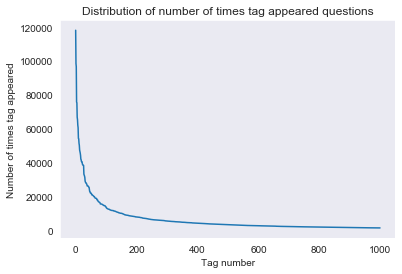

In [215]:
plt.plot(a2['Frequency'][0:1000])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

Observation:
1. We see that there are some words that repeat multiple times.
2. There are 1.4M unique words in the Cleaned_Title.
3. Not all the words are important and hence we take only the top 1000 words and experiment

In [220]:
cleaned1=list(data['Cleaned_Title'])

In [234]:
aa=a2['Word'][0:1000]

In [237]:
gg=[]
ff=[]
for k in (range(0,len(cleaned1))):
    q=cleaned1[k].split()
    for i in aa:
        for j in q:
            if (i==j):
                gg.append(i)
    ff.append(gg)
    gg=[]

In [254]:
len(ff)

1396270

In [255]:
len(data)

1396270

In [246]:
ff1=[]
for i in range(0,len(ff)):
    ff1.append(' '.join(ff[i])) 

In [256]:
len(ff1)

1396270

In [265]:
data=data.reset_index()

In [272]:
data['LDA']=ff1

In [273]:
data.head()

,Title,Tokens,Cleaned_Title,Title_Length,Token_Space,LDA
0,implementing boundary value analysis of softwa...,"[c++, testing]",implementing boundary value analysis software ...,74,c++ testing,value c++ program testing implementing software
1,java.lang.noclassdeffounderror: javax/servlet/...,"[java, jsp]",java lang noclassdeffounderror javax servlet j...,76,java jsp,java jsp lang servlet
2,java.sql.sqlexception:[microsoft][odbc driver ...,"[java, sql]",java sql sqlexception microsoft odbc driver ma...,79,java sql,java sql index invalid microsoft manager driver
3,better way to update feed on fb with php sdk,[php],better way update feed fb php sdk,44,php,php way update sdk better feed
4,"""sql injection"" issue preventing correct form ...","[php, sql]",sql injection issue preventing correct form su...,62,php sql,- php sql form issue correct


1. In the new column LDA we have only the words which were present in the top 1000 words.
2. We use column LDA to train the LDA model

In [3]:
data_main_clean_v5=data

In [276]:
data_main_clean_v5.to_pickle('data_main_clean_v5.pickle')

1. Storing to a picke file

In [4]:
data1=data_main_clean_v5

## Preparing to train LDA

In [5]:
# Converting each title to comma seperated list 
b=[]
c=[]
for i in range(0,len(data1)):
    a=data1['LDA'][i].split()
    a=list(a)
    c.append(a)

In [6]:
len(c)

1396270

In [8]:
dictionary = gensim.corpora.Dictionary(c)
bow_corpus = [dictionary.doc2bow(doc) for doc in c]
bow_corpus[0:10]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(6, 1), (7, 1), (8, 1), (9, 1)],
 [(6, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)],
 [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)],
 [(15, 1), (18, 1), (22, 1), (23, 1), (24, 1), (25, 1)],
 [(26, 1), (27, 1), (28, 1)],
 [(29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)],
 [(29, 1), (35, 1), (36, 1)],
 [(37, 1)],
 [(35, 1), (38, 1), (39, 1), (40, 1), (41, 1)]]

1. We created a dictionary of the words from the title.
2. Since, LDA requires numeric positions to perform operations, we create bow_corpus that contain positions of the words.

# LDA USING BOW

## Trying to experiment with topics=10 and chunksize=20

In [318]:
def train_lda(data,num_topics,chunksize):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = num_topics
    chunksize = chunksize
    dictionary = corpora.Dictionary(c)
    corpus = [dictionary.doc2bow(doc) for doc in c]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(c), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [319]:
dictionary,corpus,lda = train_lda(c,num_topics=10,chunksize=20)

Time to train LDA model on  1396270 articles:  15.599941166241964 min


1. Trained LDA with number of topics as 10 and chunksize=20

In [320]:
# Top 5 relevent words to the 4th topic
lda.show_topic(topicid=4, topn=5)

[('ajax', 0.36808193),
 ('user', 0.32635704),
 ('name', 0.30547762),
 ('explorer', 8.359923e-08),
 ('mod', 8.359923e-08)]

### Now we try to test and see the recomended questions

In [321]:
# Selecting the 0th index datapoint for testing 
random_article_index = 0
bow = dictionary.doc2bow(a.iloc[random_article_index,0]) # This returns the position of the words
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)]) #This returns the distribution or values for each topic

In [323]:
new_doc_distribution

array([0.0019608 , 0.0019608 , 0.0019608 , 0.0019608 , 0.0019608 ,
       0.0019608 , 0.98235273, 0.0019608 , 0.0019608 , 0.0019608 ],
      dtype=float32)

### From this we can see that the 0th index point is very related to the 6th indexed topic. Same thing is displayed in the graph below,

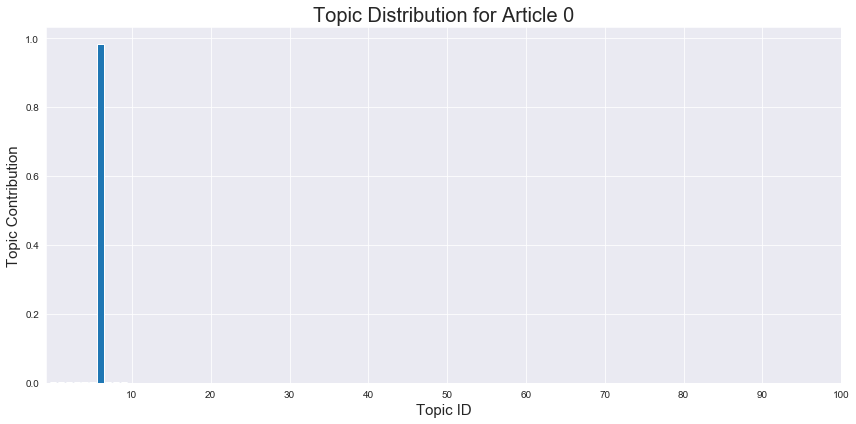

In [329]:
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [324]:
#This returns the distributions of all the points as per the 10 topics
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(1396270, 10)

In [7]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [8]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retuns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances


In [7]:
print("Query point is 'implementing boundary value analysis software testing c++ program'")

Query point is 'implementing boundary value analysis software testing c++ program'


In [17]:
import time
start_time = time.time()

# Selecting the 0th index datapoint for testing 
random_article_index = 0
bow = dictionary.doc2bow(a.iloc[random_article_index,0]) # This returns the position of the words
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)]) #This returns the distribution or values for each topic

#This returns the indices for the closely related distributions
indice=get_most_similar_documents(new_doc_distribution,doc_topic_dist,k=10)
print('TIME TAKEN TO FETCH RESULTS')
print(time.time()-start_time,'seconds')

TIME TAKEN TO FETCH RESULTS
1.1502817386143253 seconds


In [328]:
# Printing the resuts
for i in indice:
    print(data['Cleaned_Title'][i])

implementing boundary value analysis software testing c++ program
testing c++ program testing classes normally used classes
messaging service java c++ jms java java
would read image data program like image magick java
possible use java ee java java se program
conversion c++ java returning one value java
java awt image databufferint cannot cast java awt image databufferbyte
java awt image databufferbyte cannot cast java awt image databufferint
execute c++ console program c++ program
calling function c++ program function declared c++ program


## Trying to experiment with topics=30 and chunksize=50

In [9]:
def train_lda(data,num_topics,chunksize):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = num_topics
    chunksize = chunksize
    dictionary = corpora.Dictionary(c)
    corpus = [dictionary.doc2bow(doc) for doc in c]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(c), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [10]:
dictionary,corpus,lda = train_lda(c,num_topics=30,chunksize=50)

Time to train LDA model on  1396270 articles:  10.569631048043568 min


In [18]:
random_article_index = 0
bow = dictionary.doc2bow(c[0])
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

In [20]:
bow

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

In [11]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(1396270, 30)

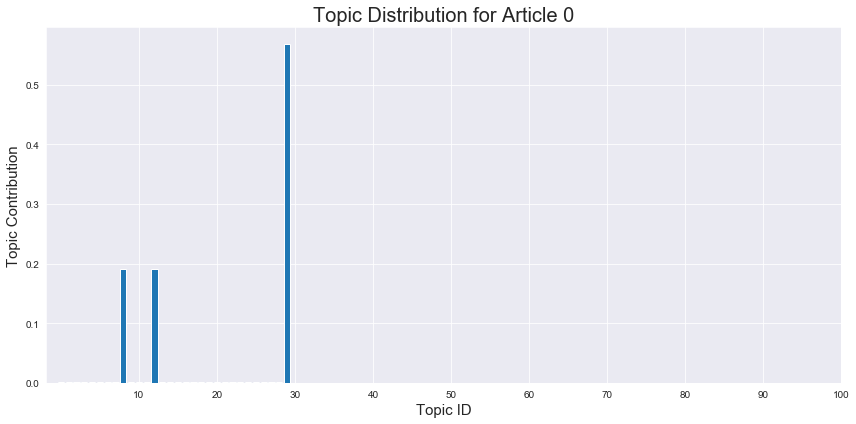

In [336]:
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

#### We see 3 topics out of 30 are contributing to the 0th query point

In [8]:
print("Query point is 'implementing boundary value analysis software testing c++ program'")

Query point is 'implementing boundary value analysis software testing c++ program'


In [19]:
import time
start_time = time.time()

# Selecting the 0th index datapoint for testing 
random_article_index = 0
bow = dictionary.doc2bow(a.iloc[random_article_index,0]) # This returns the position of the words
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)]) #This returns the distribution or values for each topic

#This returns the indices for the closely related distributions
indice=get_most_similar_documents(new_doc_distribution,doc_topic_dist,k=10)
print('TIME TAKEN TO FETCH RESULTS')
print(time.time()-start_time,'seconds')

TIME TAKEN TO FETCH RESULTS
1.302882182339201 seconds


In [335]:
for i in indice:
    print(data['Cleaned_Title'][i])

implementing boundary value analysis software testing c++ program
parse error syntax error unexpected function line 10 help
c++ cli keydown raise error error c3767 candidate function accessible
c++ program gives error value initiated
calling function c++ program function declared c++ program
html5 database value stay close browser
missing value true false needed error r
error r missing value true false needed
show content many line database one field value
c++ undefined reference function error


## Query by Applied AI

In [12]:
def Recomend(string):  
    stopwords_1 = stopwords.words("english")
    a=string
    sent_1=a.lower().strip()
    sent_1 = re.sub(r"won\'t", "will not", sent_1)
    sent_1 = re.sub(r"can\'t", "can not", sent_1)
    sent_1 = re.sub(r"n\'t", " not", sent_1)
    sent_1 = re.sub(r"\'re", " are", sent_1)
    sent_1 = re.sub(r"\'s", " is", sent_1)
    sent_1 = re.sub(r"\'d", " would", sent_1)
    sent_1 = re.sub(r"\'ll", " will", sent_1)
    sent_1 = re.sub(r"\'t", " not", sent_1)
    sent_1 = re.sub(r"\'ve", " have", sent_1)
    sent_1 = re.sub(r"\'m", " am", sent_1)
    sent_1 = re.sub('[^A-Za-z0-9-+]+', ' ', sent_1)
    sent_1 = ' '.join(e for e in sent_1.split() if e not in stopwords_1)
    sent_1=sent_1.lower().strip()
    print('QUERY ENTERED BY THE USER')
    print(a)
    print('\n')
    
    query=sent_1.split()
    bow = dictionary.doc2bow(query) # This returns the position of the words
    new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)]) #This returns the distribution or values for each topic
    indices=get_most_similar_documents(new_doc_distribution,doc_topic_dist,k=10)
    
    
    print('RECOMENDED SIMILAR QUESTIONS')
    g=0
    for i in indices:
        g=g+1
        print(g ,'th question','"',data_main_clean_v5['Cleaned_Title'][i],'"')
        print('\n')

### Query 1- how to create a linked list in python

In [17]:
import time
start_time = time.time()
Recomend('how to create a linked list in python')
print('TIME TAKEN TO FETCH RESULTS')
print(time.time()-start_time,'seconds')

QUERY ENTERED BY THE USER
how to create a linked list in python


RECOMENDED SIMILAR QUESTIONS
1 th question " open-source image processing library supports high level 3d algorithms "


2 th question " nstabview visible image view "


3 th question " extract image embedded resources temp folder execute "


4 th question " iconanchor infowindowanchor given image "


5 th question " differences python numpy ndarray list datatypes "


6 th question " stripes read list added parameter redirectresolution "


7 th question " options ininputshareable used downloading image internet "


8 th question " use tdd image rendering project "


9 th question " wpf- show cropped region imagesource image control "


10 th question " cclabelbmfont crashing due missing image message "


TIME TAKEN TO FETCH RESULTS
2.5970544815063477 seconds


C:\Users\Utsav\Miniconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


### Query 2- LSTM with keras

In [19]:
import time
start_time = time.time()
Recomend('LSTM with keras')
print('TIME TAKEN TO FETCH RESULTS')
print(time.time()-start_time,'seconds')

QUERY ENTERED BY THE USER
LSTM with keras


RECOMENDED SIMILAR QUESTIONS
1 th question " disable version control features qt creator "


2 th question " problem getting tooltip refresh properly itemrenderer flex "


3 th question " errors crawling content sources sharepoint 2010 "


4 th question " purpose boolean switch statements javascript "


5 th question " errors computing psd inside parfor loops loops "


6 th question " problem hosting wcf service iis express "


7 th question " errors logged http https response 200 "


8 th question " errors reported iphone mfmailcomposeviewcontroller safe "


9 th question " problem imitating vs output window textbox wpf textbox "


10 th question " problem getting tomcat start reboot "


TIME TAKEN TO FETCH RESULTS
2.4983396530151367 seconds


## Trying to experiment with topics=100 and chunksize=100

In [337]:
def train_lda(data,num_topics,chunksize):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = num_topics
    chunksize = chunksize
    dictionary = corpora.Dictionary(c)
    corpus = [dictionary.doc2bow(doc) for doc in c]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(c), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [338]:
dictionary,corpus,lda = train_lda(c,num_topics=100,chunksize=100)

Time to train LDA model on  1396270 articles:  12.829964486757914 min


In [339]:
random_article_index = 0
bow = dictionary.doc2bow(a.iloc[random_article_index,0])
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(1396270, 100)

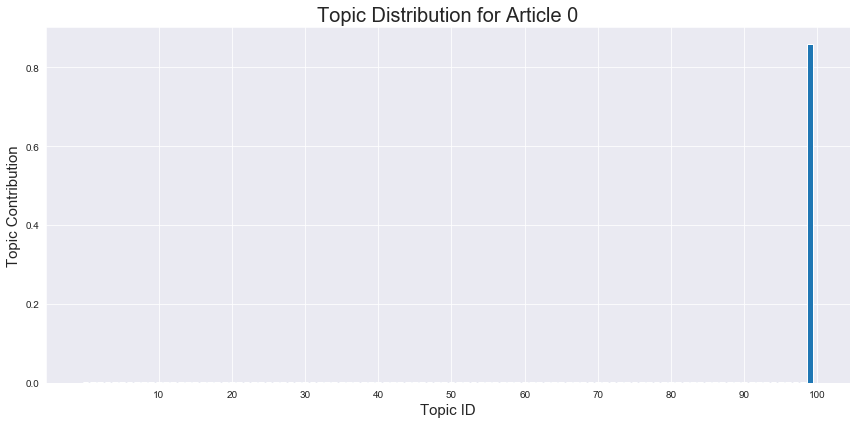

In [342]:
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [9]:
print("Query point is 'implementing boundary value analysis software testing c++ program'")

Query point is 'implementing boundary value analysis software testing c++ program'


In [18]:
import time
start_time = time.time()

# Selecting the 0th index datapoint for testing 
random_article_index = 0
bow = dictionary.doc2bow(a.iloc[random_article_index,0]) # This returns the position of the words
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)]) #This returns the distribution or values for each topic

#This returns the indices for the closely related distributions
indice=get_most_similar_documents(new_doc_distribution,doc_topic_dist,k=10)
print('TIME TAKEN TO FETCH RESULTS')
print(time.time()-start_time,'seconds')

TIME TAKEN TO FETCH RESULTS
1.3962362328607235 seconds


In [341]:
for i in indice:
    print(data['Cleaned_Title'][i])

implementing boundary value analysis software testing c++ program
execute c++ console program c++ program
testing c++ program testing classes normally used classes
writing program open use another program audio program
cache hit miss value c c++ program
read trackbar control value c++ winapi program
changing value stdout c++ program
advantages c++ cli formerly managed c++ standard c++
compiling small c++ program visual c++ express
c++ program gives error value initiated


Observation:
1. Trying out different number of topics gave us different results.
2. The model with 30 and 100 topics works good as it is recomending results with C++ and testing kind of resuts within them.
3. Test time complexity is quite under control due to consideration of only top 1000 words.

# LDA USING TFIDF

### Training TFIDF LDA with num_topics as 10 and chunksize as 20

In [56]:
dictionary = gensim.corpora.Dictionary(c) #Building Dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in c] #BOW corpus to give positions
tfidf = models.TfidfModel(bow_corpus) #This internally builds a tfidf model based on BOW_CORPUS
corpus_tfidf = tfidf[bow_corpus] #This returns each sentence representations as (word_position,TFIDF of that word)

In [57]:
print(corpus_tfidf[1000])

[(68, 0.2547659112061909), (182, 0.6780021538465144), (320, 0.5362615646917638), (444, 0.3099085293797901), (550, 0.30296476283350743)]


In [58]:
def train_lda(data,num_topics,chunksize):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = num_topics
    chunksize = chunksize
    dictionary = corpora.Dictionary(c)
    corpus = [dictionary.doc2bow(doc) for doc in c]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[bow_corpus]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus_tfidf, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(c), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus_tfidf,lda

In [59]:
dictionary,corpus_tfidf,lda=train_lda(c,10,20)

Time to train LDA model on  1396270 articles:  8.91610167423884 min


In [74]:
random_article_index = 0
bow = dictionary.doc2bow(c[0])

In [75]:
corpus_tfidf_test = tfidf[bow] # This is like transforming to the pre trained tfidf model
corpus_tfidf_test

[(0, 0.3046469245917836),
 (1, 0.491546495417912),
 (2, 0.39322966101805484),
 (3, 0.49733840611751406),
 (4, 0.414989535538461),
 (5, 0.30229277707021907)]

In [76]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=corpus_tfidf_test)])

In [60]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus_tfidf]])
doc_topic_dist.shape 

(1396270, 10)

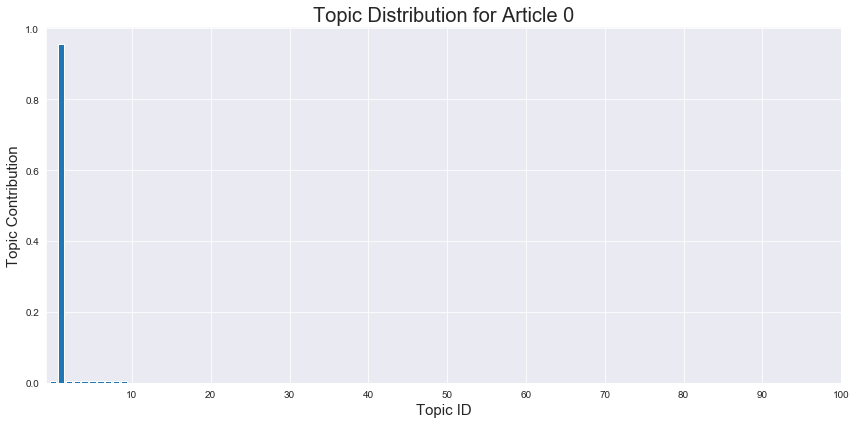

In [77]:
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [79]:
import time
print("Query point is 'implementing boundary value analysis software testing c++ program'\n")
start_time = time.time()
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=corpus_tfidf_test)])
indice=get_most_similar_documents(new_doc_distribution,doc_topic_dist,k=10)
for i in indice:
    print(data['Cleaned_Title'][i])
    print('\n')
print('TIME TAKEN TO FETCH RESULTS')
print(time.time()-start_time,'seconds')

Query point is 'implementing boundary value analysis software testing c++ program'

implementing boundary value analysis software testing c++ program


serendipity booksellers software program c++


testing xml xmlunit variable value


hardcode value texbox c++


boundary value analysis c++ cppunit


bignum divison value assignment c++


extending lifetime temporary value c++


insertion pair mapped value multimap c++


polymorphic containers value semantics c++


xerces c++ xml escape really hard


TIME TAKEN TO FETCH RESULTS
1.3981478214263916 seconds


In [11]:
dictionary = gensim.corpora.Dictionary(c) #Building Dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in c] #BOW corpus to give positions
tfidf = models.TfidfModel(bow_corpus) #This internally builds a tfidf model based on BOW_CORPUS
corpus_tfidf = tfidf[bow_corpus] #This returns each sentence representations as (word_position,TFIDF of that word)

In [63]:
print(corpus_tfidf[1000])

[(68, 0.2547659112061909), (182, 0.6780021538465144), (320, 0.5362615646917638), (444, 0.3099085293797901), (550, 0.30296476283350743)]


### Applied AI query

In [63]:
def Recomend(string):  
    stopwords_1 = stopwords.words("english")
    a=string
    sent_1=a.lower().strip()
    sent_1 = re.sub(r"won\'t", "will not", sent_1)
    sent_1 = re.sub(r"can\'t", "can not", sent_1)
    sent_1 = re.sub(r"n\'t", " not", sent_1)
    sent_1 = re.sub(r"\'re", " are", sent_1)
    sent_1 = re.sub(r"\'s", " is", sent_1)
    sent_1 = re.sub(r"\'d", " would", sent_1)
    sent_1 = re.sub(r"\'ll", " will", sent_1)
    sent_1 = re.sub(r"\'t", " not", sent_1)
    sent_1 = re.sub(r"\'ve", " have", sent_1)
    sent_1 = re.sub(r"\'m", " am", sent_1)
    sent_1 = re.sub('[^A-Za-z0-9-+]+', ' ', sent_1)
    sent_1 = ' '.join(e for e in sent_1.split() if e not in stopwords_1)
    sent_1=sent_1.lower().strip()
    print('QUERY ENTERED BY THE USER')
    print(a)
    print('\n')
    
    query=sent_1.split()
    bow = dictionary.doc2bow(query) # This returns the position of the words
    corpus_tfidf_test = tfidf[bow] #This internally builds a tfidf model based on BOW_CORPUS
    new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=corpus_tfidf_test)]) #This returns the distribution or values for each topic
    indices=get_most_similar_documents(new_doc_distribution,doc_topic_dist,k=10)
    
    
    print('RECOMENDED SIMILAR QUESTIONS')
    g=0
    for i in indices:
        g=g+1
        print(g ,'th question','"',data_main_clean_v5['Cleaned_Title'][i],'"')
        print('\n')

In [64]:
import time
start_time = time.time()
Recomend('how to create a linked list in python')
print('TIME TAKEN TO FETCH RESULTS')
print(time.time()-start_time,'seconds')

QUERY ENTERED BY THE USER
how to create a linked list in python




C:\Users\Utsav\Miniconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


RECOMENDED SIMILAR QUESTIONS
1 th question " create view contain image text like newspaper "


2 th question " stick image bottom visible screen centered "


3 th question " trace chmod 640 ed etc passwd file "


4 th question " values pulling ruby array c extension wrong "


5 th question " get file descriptor handle filestream "


6 th question " inilne event registration vs advanced registration image validation "


7 th question " build automation code review deployment system grails "


8 th question " python csv finding rows biggest values "


9 th question " symfony2 avalancheimaginebundle merge image filter "


10 th question " genrating designer file asp net application "


TIME TAKEN TO FETCH RESULTS
1.653294563293457 seconds


In [65]:
import time
start_time = time.time()
Recomend('LSTM with Keras')
print('TIME TAKEN TO FETCH RESULTS')
print(time.time()-start_time,'seconds')

QUERY ENTERED BY THE USER
LSTM with Keras


RECOMENDED SIMILAR QUESTIONS
1 th question " scrolling touch devices phonegap cordova projects "


2 th question " delphi 2009 converts delphi 7 projects build configurations "


3 th question " debug jsp pages eclipse+maven+jetty "


4 th question " viewing http headers wcf service "


5 th question " viewing contents previous commits xcode "


6 th question " viewing output visual studio xslt debugger "


7 th question " dns works iterative recursive queries "


8 th question " dns service discovery multicast dns bonjour related "


9 th question " possible varchar hash indexing structure mysql "


10 th question " viewing uploaded pdf doc pictures without converting "


TIME TAKEN TO FETCH RESULTS
1.2918615341186523 seconds


### Training TFIDF LDA with num_topics as 30 and chunksize as 50

1. We choosed this combination as it worked well in BOW LDA

In [27]:
def train_lda(data,num_topics,chunksize):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = num_topics
    chunksize = chunksize
    dictionary = corpora.Dictionary(c)
    corpus = [dictionary.doc2bow(doc) for doc in c]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[bow_corpus]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus_tfidf, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(c), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus_tfidf,lda

In [29]:
dictionary,corpus_tfidf,lda=train_lda(c,30,50)

Time to train LDA model on  1396270 articles:  16.363105710347494 min


In [44]:
random_article_index = 0
bow = dictionary.doc2bow(c[0])
corpus_tfidf_test = tfidf[bow] # This is like transforming to the pre trained tfidf model
corpus_tfidf_test

new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=corpus_tfidf_test)])

[(0, 0.3046469245917836),
 (1, 0.491546495417912),
 (2, 0.39322966101805484),
 (3, 0.49733840611751406),
 (4, 0.414989535538461),
 (5, 0.30229277707021907)]

In [47]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus_tfidf]])
doc_topic_dist.shape 

(1396270, 30)

This returns the distribution as per 30 topics for each point in data

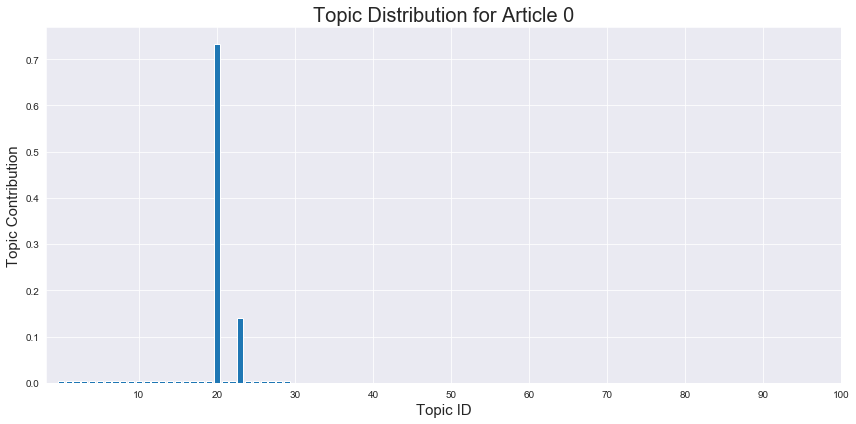

In [48]:
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

We can see two topics are majaorly contributing to the first data point

In [62]:
import time
print("Query point is 'implementing boundary value analysis software testing c++ program'\n")
start_time = time.time()
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=corpus_tfidf_test)])
indice=get_most_similar_documents(new_doc_distribution,doc_topic_dist,k=10)
for i in indice:
    print(data['Cleaned_Title'][i])
    print('\n')
print('TIME TAKEN TO FETCH RESULTS')
print(time.time()-start_time,'seconds')

Query point is 'implementing boundary value analysis software testing c++ program'

implementing boundary value analysis software testing c++ program


python testing none testing boolean value


compiling c++ program mysql h linux


testing session set particular value


warning control paths return value mean c++


changing value stdout c++ program


read trackbar control value c++ winapi program


causing program crash mysql connector c++


session value set session start available page preinit


make simple c++ server-client software


TIME TAKEN TO FETCH RESULTS
4.027257919311523 seconds
